Aluna: Márcia Thais Revorêdo Aires - 122210330


Laboratório de Redes de Computadores: Implementação e Análise do CRC

**Parte 2: Implementação Manual do Algoritmo CRC**

In [13]:
def xor_bits(a, b):
    """
    Realiza a operação de XOR bit a bit entre duas strings binárias de mesmo comprimento.
    """
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    """
    Calcula o CRC para uma sequência de dados M(x) usando um gerador G(x).

    Args:
        dados_bits: A string binária representando o polinômio da mensagem, M(x).
        gerador_bits: A string binária representando o polinômio gerador, G(x).

    Returns:
        A string binária de r bits representando o CRC.
    """
    # 1. Grau do gerador (r)
    r = len(gerador_bits) - 1

    # 2. Mensagem aumentada com r bits 0 no final (M(x) * 2^r)
    mensagem_aumentada = list(dados_bits + '0' * r)

    # 3. Loop de divisão binária (XOR)
    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            # Pega a janela de r+1 bits (o mesmo comprimento do gerador)
            inicio = i
            fim = i + len(gerador_bits)
            janela_atual = "".join(mensagem_aumentada[inicio:fim])

            # Aplica XOR entre a janela atual e o gerador
            resultado_xor = xor_bits(janela_atual, gerador_bits)

            # Atualiza os bits da mensagem com o resultado do XOR
            for j in range(len(resultado_xor)):
                mensagem_aumentada[inicio + j] = resultado_xor[j]

    # 4. O resto (CRC) são os r bits finais
    resto = "".join(mensagem_aumentada[-r:])
    return resto


In [14]:
# Exemplo de uso para validação
dados_teste = "1101011111"  # M(x)
gerador_teste = "10011"    # G(x)
crc_calculado = calcular_crc_manual(dados_teste, gerador_teste)

print(f"Dados M(x): {dados_teste}")
print(f"Gerador G(x): {gerador_teste}")
print(f"CRC Calculado: {crc_calculado}")
quadro_tx = dados_teste + crc_calculado
print(f"Quadro a ser transmitido: {quadro_tx}")

Dados M(x): 1101011111
Gerador G(x): 10011
CRC Calculado: 0010
Quadro a ser transmitido: 11010111110010


**Parte 3: Análise Comparativa de Desempenho**

In [ ]:
pip install crc


🔍 Testando mensagem com 1500 bytes...

🔍 Testando mensagem com 4500 bytes...

🔍 Testando mensagem com 9000 bytes...


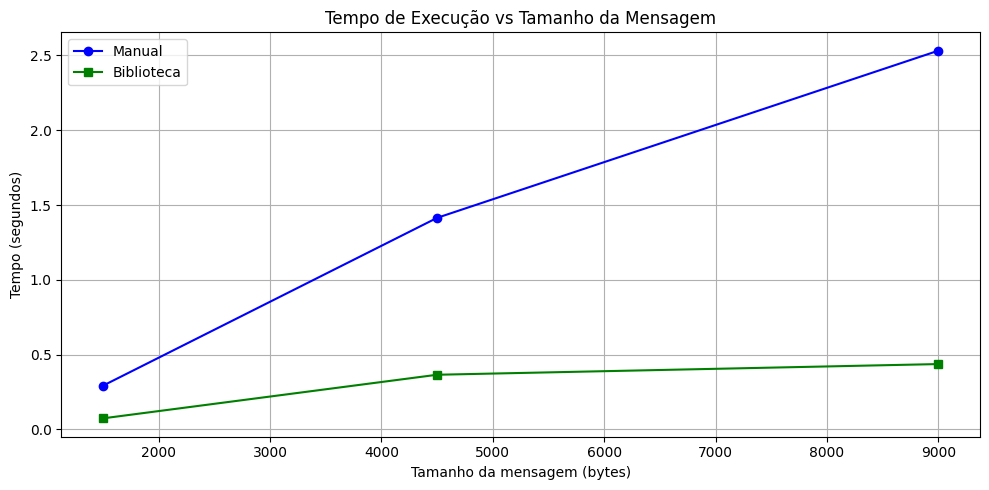

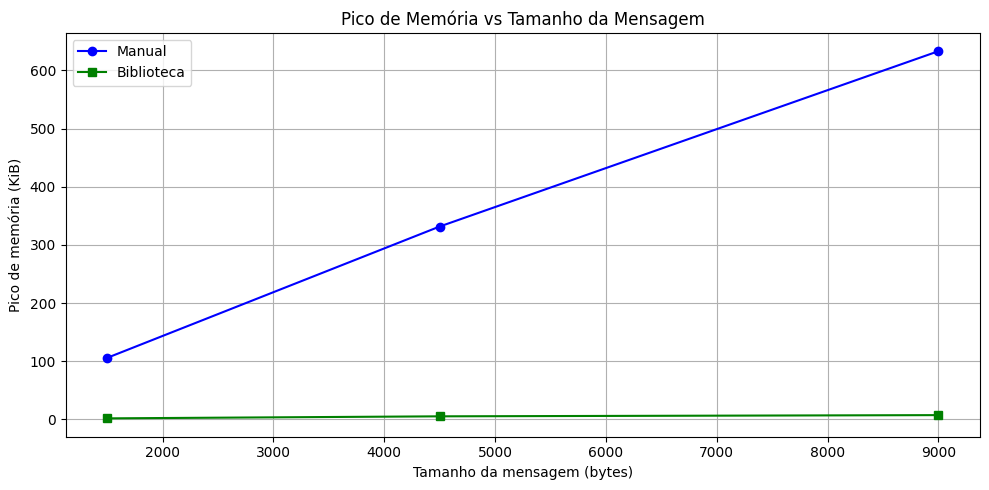

In [ ]:
import time
import tracemalloc
import os
import matplotlib.pyplot as plt
from crc import Calculator, Crc16

def xor_bits(a, b):
    resultado = ""
    for i in range(len(a)):
        if a[i] == b[i]:
            resultado += '0'
        else:
            resultado += '1'
    return resultado

def calcular_crc_manual(dados_bits: str, gerador_bits: str) -> str:
    r = len(gerador_bits) - 1
    mensagem_aumentada = list(dados_bits + '0' * r)
    for i in range(len(dados_bits)):
        if mensagem_aumentada[i] == '1':
            inicio = i
            fim = i + len(gerador_bits)
            janela_atual = "".join(mensagem_aumentada[inicio:fim])
            resultado_xor = xor_bits(janela_atual, gerador_bits)
            for j in range(len(resultado_xor)):
                mensagem_aumentada[inicio + j] = resultado_xor[j]
    return "".join(mensagem_aumentada[-r:])

calculator_lib = Calculator(Crc16.MODBUS)
tamanhos_bytes = [1500, 4500, 9000]
gerador_crc16 = "11000000000000101"  # Polinômio CRC-16/MODBUS

resultados = []

for tamanho in tamanhos_bytes:
    print(f"\n🔍 Testando mensagem com {tamanho} bytes...")
    mensagem_bytes = os.urandom(tamanho)
    mensagem_bits = "".join(format(byte, '08b') for byte in mensagem_bytes)

    # Teste CRC manual
    tracemalloc.start()
    start = time.perf_counter()
    crc_m = calcular_crc_manual(mensagem_bits, gerador_crc16)
    end = time.perf_counter()
    mem_atual, mem_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tempo_m = end - start
    pico_manual = mem_pico / 1024  # em KiB

    # Teste CRC da biblioteca
    tracemalloc.start()
    start = time.perf_counter()
    crc_l = calculator_lib.checksum(mensagem_bytes)
    end = time.perf_counter()
    mem_atual_l, mem_pico_l = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    tempo_l = end - start
    pico_lib = mem_pico_l / 1024  # em KiB

    # Salva os dados
    resultados.append({
        "tamanho": tamanho,
        "tempo_manual": tempo_m,
        "mem_manual": pico_manual,
        "tempo_lib": tempo_l,
        "mem_lib": pico_lib
    })

tamanhos = [r["tamanho"] for r in resultados]

tempos_manual = [r["tempo_manual"] for r in resultados]
tempos_lib = [r["tempo_lib"] for r in resultados]

mem_manual = [r["mem_manual"] for r in resultados]
mem_lib = [r["mem_lib"] for r in resultados]

# Gráfico 1: Tempo
plt.figure(figsize=(10, 5))
plt.plot(tamanhos, tempos_manual, marker='o', label='Manual', color='blue')
plt.plot(tamanhos, tempos_lib, marker='s', label='Biblioteca', color='green')
plt.title("Tempo de Execução vs Tamanho da Mensagem")
plt.xlabel("Tamanho da mensagem (bytes)")
plt.ylabel("Tempo (segundos)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("grafico_tempo_crc.png")
plt.show()

# Gráfico 2: Memória
plt.figure(figsize=(10, 5))
plt.plot(tamanhos, mem_manual, marker='o', label='Manual', color='blue')
plt.plot(tamanhos, mem_lib, marker='s', label='Biblioteca', color='green')
plt.title("Pico de Memória vs Tamanho da Mensagem")
plt.xlabel("Tamanho da mensagem (bytes)")
plt.ylabel("Pico de memória (KiB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("grafico_memoria_crc.png")
plt.show()

**Especificação da máquina:**

    Sistema Operacional: Ubuntu 22.04.2 LTS
    Processador (CPU): AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx
    Memória RAM: 12 GB




Comparando a função calcular_crc_manual com a biblioteca otimizada (crc), observamos uma diferença significativa em desempenho, tanto em tempo de execução quanto no uso de memória.

- Tempo de Execução: A biblioteca padrão foi consideravelmente mais rápida, especialmente com mensagens maiores. Isso se deve ao fato de estar implementada em linguagens de baixo nível (como C) e otimizada com tabelas de consulta e operações em nível de byte, enquanto a implementação manual faz operações bit a bit, o que é naturalmente mais lento em Python.

- Uso de Memória: A versão manual também consumiu mais memória, já que opera com strings longas de bits, enquanto a biblioteca trabalha com estruturas binárias mais compactas (bytes).

A análise reforça a importância de usar bibliotecas otimizadas em aplicações reais, especialmente quando o desempenho é crítico (como em redes de alta velocidade). Ainda assim, a implementação manual é essencial para fins didáticos e para entender profundamente o funcionamento do algoritmo de CRC.

**Parte 4: Análise Investigativa da Detecção de Erros (Cenário Personalizado)**

**Preparação do cenário:**

VARIAVEL ->	VALOR

MENSAGEM ->	Marcia Thais Revoredo Aires

MENSAGEM_BASE ->	01001101 01100001 01110010 01100011 01101001 01100001 00100000 01010100 01101000 01100001 01101001 01110011 00100000 01010010 01100101 01110110 01101111 01110010 01100101 01100100 01101111 00100000 01000001 01101001 01110010 01100101 01110011

CRC -> CRC-16/MODBUS (11000000000000101 ou x 16 + x 15 + x 2 + 1 ) -> 11000000000000101


**4.2 - A Caça aos Erros**

In [15]:
import random

def string_to_bits(s):
    """Converte uma string para representação binária (ASCII, 8 bits por caractere)"""
    return ''.join(format(ord(c), '08b') for c in s)

def flip_bits(bits, start_pos, n):
    """Inverte 'n' bits começando na posição 'start_pos'"""
    bits_list = list(bits)
    for i in range(start_pos, min(start_pos + n, len(bits_list))):
        bits_list[i] = '1' if bits_list[i] == '0' else '0'
    return ''.join(bits_list)

def test_error_detection(message_bits, generator_bits, num_tests=10):
    """Testa a detecção de erros aleatórios"""
    results = []

    # Calcula o CRC da mensagem original
    original_crc = calcular_crc_manual(message_bits, generator_bits)
    transmitted_frame = message_bits + original_crc

    for test_num in range(1, num_tests + 1):
        # Escolhe uma posição e tamanho de erro aleatórios
        max_pos = len(transmitted_frame) - 1
        error_pos = random.randint(0, max_pos)
        error_length = random.randint(1, 16)  # Até 16 bits de erro

        # Cria o padrão de erro (todos 1s para inverter os bits)
        error_pattern = '1' * error_length

        # Corrompe o quadro transmitido
        corrupted_frame = flip_bits(transmitted_frame, error_pos, error_length)

        # Calcula o CRC do quadro corrompido
        # (precisamos separar os dados originais do CRC anexado)
        data_part = corrupted_frame[:-len(generator_bits)+1]
        crc_part = corrupted_frame[-len(generator_bits)+1:]

        # Verifica com nossa implementação manual
        manual_crc = calcular_crc_manual(data_part, generator_bits)
        manual_detected = manual_crc != ('0' * (len(generator_bits)-1))

        # Verifica com a biblioteca (precisamos converter de bits para bytes)
        try:
            # Converte os bits para bytes
            data_bytes = bits_to_bytes(data_part)
            calculator = Calculator(Crc16.MODBUS)
            lib_crc = calculator.checksum(data_bytes)

            # Converte o CRC calculado para string binária
            lib_crc_bits = format(lib_crc, '016b')
            lib_detected = lib_crc != 0
        except:
            # Em caso de erro na conversão (mensagem não múltiplo de 8), consideramos como detectado
            lib_detected = True

        # Registra os resultados
        results.append({
            'Teste': test_num,
            'Posição do erro': error_pos,
            'Tamanho do erro (bits)': error_length,
            'Erro detectado (manual)': manual_detected,
            'Erro detectado (biblioteca)': lib_detected,
            'Padrão de erro': f"{error_pos}:{error_length} bits"
        })

    return results

def bits_to_bytes(bits):
    """Converte string de bits para bytes"""
    # Completa com zeros se necessário para ter um múltiplo de 8
    padding = (8 - len(bits) % 8) % 8
    padded_bits = bits + '0' * padding

    bytes_list = []
    for i in range(0, len(padded_bits), 8):
        byte_bits = padded_bits[i:i+8]
        bytes_list.append(int(byte_bits, 2))

    return bytes(bytes_list)

# Configuração do teste
MENSAGEM = "Marcia Thais Revoredo Aires"
MENSAGEM_BASE = string_to_bits(MENSAGEM)
GERADOR = "11000000000000101"  # CRC-16/MODBUS

# Executa os testes
resultados_teste = test_error_detection(MENSAGEM_BASE, GERADOR, 10)

# Exibe os resultados
print("Resultados dos testes de detecção de erros:")
print("-" * 80)
print(f"{'Teste':<6} | {'Posição':<10} | {'Tamanho':<8} | {'Detectado (Manual)':<18} | {'Detectado (Lib)':<15} | Padrão de erro")
print("-" * 80)
for res in resultados_teste:
    print(f"{res['Teste']:<6} | {res['Posição do erro']:<10} | {res['Tamanho do erro (bits)']:<8} | "
          f"{'SIM' if res['Erro detectado (manual)'] else 'NÃO':<18} | "
          f"{'SIM' if res['Erro detectado (biblioteca)'] else 'NÃO':<15} | {res['Padrão de erro']}")

Resultados dos testes de detecção de erros:
--------------------------------------------------------------------------------
Teste  | Posição    | Tamanho  | Detectado (Manual) | Detectado (Lib) | Padrão de erro
--------------------------------------------------------------------------------
1      | 116        | 9        | SIM                | SIM             | 116:9 bits
2      | 166        | 2        | SIM                | SIM             | 166:2 bits
3      | 157        | 8        | SIM                | SIM             | 157:8 bits
4      | 31         | 10       | SIM                | SIM             | 31:10 bits
5      | 63         | 16       | SIM                | SIM             | 63:16 bits
6      | 158        | 16       | SIM                | SIM             | 158:16 bits
7      | 166        | 12       | SIM                | SIM             | 166:12 bits
8      | 191        | 6        | SIM                | SIM             | 191:6 bits
9      | 18         | 12       | SIM     

**Reportando o Ponto Cego**

In [17]:
# Mensagem original e CRC
message_bits = "010011010110000101110010011000110110100101100001001000000101010001101000011000010110100101110011001000000101001001100101011101100110111101110010011001010110010001101111001000000100000101101001011100100110010101110011"
generator_bits = "11000000000000101"  # CRC-16/MODBUS

# Calcula o CRC original
original_crc = calcular_crc_manual(message_bits, generator_bits)
transmitted_frame = message_bits + original_crc

# Cria um erro que é múltiplo do polinômio gerador
error_position = 50  # Posição arbitrária
error_pattern = generator_bits  # Usa o próprio gerador como erro

# Aplica o erro
corrupted_frame = transmitted_frame[:error_position] + \
                 xor_bits(transmitted_frame[error_position:error_position+len(error_pattern)], error_pattern) + \
                 transmitted_frame[error_position+len(error_pattern):]

# Verifica a detecção
data_part = corrupted_frame[:-len(generator_bits)+1]
manual_crc = calcular_crc_manual(data_part, generator_bits)
manual_detected = manual_crc != ('0' * (len(generator_bits)-1))

# Verifica com a biblioteca
data_bytes = bits_to_bytes(data_part)
calculator = Calculator(Crc16.MODBUS)
lib_crc = calculator.checksum(data_bytes)
lib_detected = lib_crc != 0

print(f"Erro não detectado (manual): {not manual_detected}")
print(f"Erro não detectado (biblioteca): {not lib_detected}")

Erro não detectado (manual): False
Erro não detectado (biblioteca): False
